# PyTorch CIFAR-10 categorisation project

1. Explore the data
1. Create a baseline to judge results against
1. Implement a neural network
1. Implement improvements
1. Evaluate different parameters

## 1. Explore the data

In [1]:
import torch
from torch import cuda
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision import transforms
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path

In [2]:
data_folder = r"../data"

transform = transforms.Compose([transforms.Resize(32),
                                transforms.ToTensor()])
CIFAR_data = CIFAR10(data_folder, train=True, transform=transform, download=True)

train_dataloader = DataLoader(CIFAR_data,
                          batch_size=4,
                          shuffle=True)

CIFAR_test_data = CIFAR10(data_folder, train=False, transform=transform)

test_dataloader = DataLoader(CIFAR_test_data,
                              batch_size=4,
                              shuffle=True)

Files already downloaded and verified


### Visualise data

The next cell creates train_X, train_y type data which we use to visualise the data and run our benchmark categorisation. The training of Neural Nets uses PyTorch dataloaders and not the objects created in cell below.

To help with initial data exploration, convert the entire data training set to 
tensors.

In [3]:
# to do that explicitly below. Images in DataLoader objects have pixel values
# in (0,1). The CIFAR_data.data has int values in (0,255) so have to convert
# to floats to take mean etc further down
train_imgs = torch.tensor(CIFAR_data.data).float()/255
train_y = torch.tensor(CIFAR_data.targets)
test_imgs = torch.tensor(CIFAR_test_data.data).float()/255
test_y = torch.tensor(CIFAR_test_data.targets)

classes = CIFAR_data.classes

# We need a map to get from index to class name.
# So need to reverse .class_to_idx dict:
labels_map = {}
for key, val in CIFAR_data.class_to_idx.items():
    labels_map[val] = key

Plot random sample of the data:

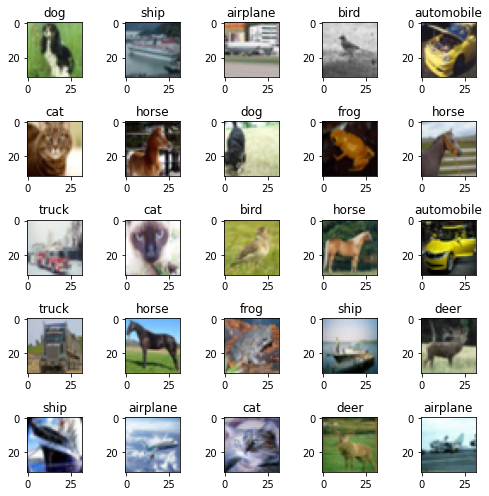

In [4]:
fig, axs = plt.subplots(5,5,figsize=(7,7))

for ax in axs.flatten():
    i = torch.randint(50000, (1,1)).item()
    ax.imshow(train_imgs[i])
    ax.set_title(labels_map[train_y[i].item()])
plt.tight_layout()

## Prepare data for benchmark categorisation

We create the training and validation data and labels.

The data is reshaped to a 4-dimensional tensor. dim 0 corresponds to list of images dim 1 is "depth" - so 3 layers for RGB; dim 2 and 3 are for the 32 pixels height and width of the images. 

We didvide pixel values by 255 so that PyTorch can work with floating point numbers in (0,1).

In [5]:
test_y.shape, test_imgs.shape, train_y.shape, train_imgs.shape

(torch.Size([10000]),
 torch.Size([10000, 32, 32, 3]),
 torch.Size([50000]),
 torch.Size([50000, 32, 32, 3]))

## Create a benchmark to judge neural net results against

Will an accuracy of above 10% imply that our neural net is doing better than chance and therefore doing a good job? Maybe.

To create a benchmark, we do a very simple prediction: we calculate the value of the "average" pixel for all the images in each category. Then for each image, we 

First create a benchmark to measure results of training neural net on.

We calculate the average RGB value for each pixel for each category. Then calculate the distance of an image form the average image for each category. Shortest distance is classified as that image. Can we do better than 10% accuracy??

In [6]:
avg_img = torch.zeros((10,32,32,3))
for i in np.arange(10):
    mask = train_y == i
    avg_img[i] = train_imgs[mask].mean(0)
    

Display our "average images". Kinda cool! The automobile and truck look like vehicles coming through the mist and the colours look different for different categories. There will be a lot of confusion between wild animals and cars/trucks for example, but the prediction based on distance from mean image should be quite good.

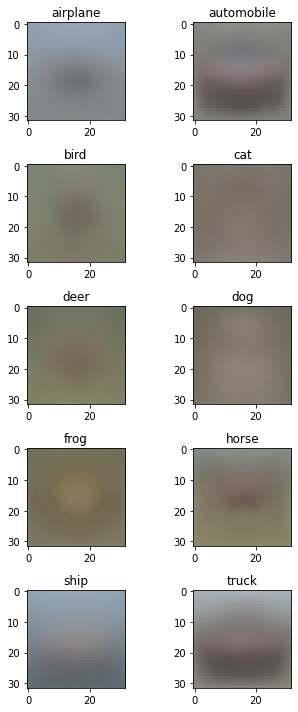

In [7]:
fig, axs = plt.subplots(5,2,figsize=(5,10))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(avg_img[i])
    ax.set_title(labels_map[i])
plt.tight_layout()

Test our benchmark prediction. 28%!! Pretty good for just calculating an average. We now need our neural net to outperform 28% accuracy to be any good.

In [8]:
def cifar_distance(a,b): return ((a-b)**2).abs().mean((-1,-2,-3))
def predictions(a): return torch.argmin(a, dim=1)

preds = predictions(cifar_distance(test_imgs[:,None], avg_img[None]))
accuracy = (preds == test_y).sum()/test_imgs.shape[0]
accuracy

tensor(0.2774)

Just for curiousity, let's plot the confusion matrix. Some parts are as we expect from out crude method: it gets confused between deer and frogs (green backgrounds?) and birds and planes (sky?). 

Finally, there were 1000 of each category in the 10,000 test data set. However, our simple rule predicted either airplane or frog 4,500 times. So a lot of images look like the average frog or airplane!

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([2016,  657,  378,  211,  432, 1065, 2485,  622,  885, 1249]))

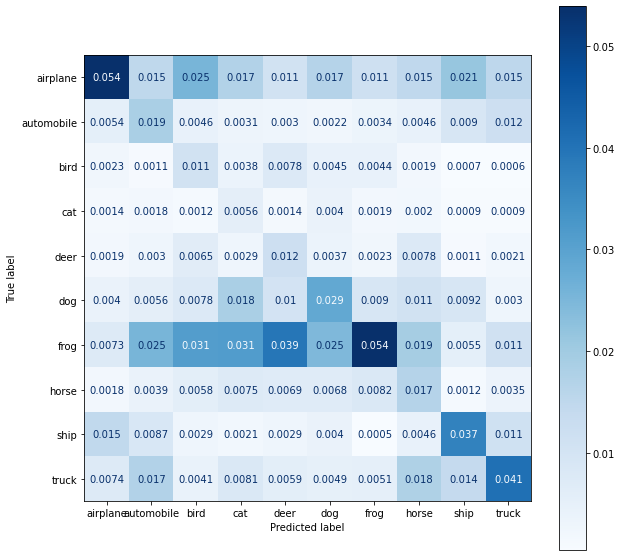

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
display(torch.unique(preds, return_counts=True))

cm = confusion_matrix(preds, test_y,
                      normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes
                             )

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap='Blues')
ax.grid(False)

## 3. Implement a neural network

Create the initial neural network

In [10]:
device = torch.device('cuda:0' if cuda.is_available() else 'cpu')
device

device(type='cpu')

Prepare the data. To check code runs, I will do a tiny amount of training data.

We also flatten the image data to vectors so that we can feed into a basic NN.

In [11]:
num_epochs = 50
batch_size = 100
learning_rate = 0.005

# I wasn't going to copy Cactus_classification, but defining 'criterion'
# gives good flexibility
criterion = nn.CrossEntropyLoss()

#### Prepare data

The code below is almost an exact copy of cell 2, above. We've recreated to give us the flexibility to have a smaller training and test set whilst running on local machines. We also have target tranform below which one-hot-encodes the labels.

In [12]:
transform = transforms.Compose([transforms.ToTensor(), #transforms.Resize(32),
                                # transforms.Lambda(lambda x: torch.flatten(x))
                               ])
target_transforms = transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float)
                                     .scatter_(0, torch.tensor(y), value=1))

# Prepare 1000 sample training set
CIFAR_data_small = CIFAR10(data_folder, train=True, 
                           transform=transform,
                           target_transform=target_transforms,
                           download=False)
CIFAR_data_small.data = CIFAR_data_small.data[:]
CIFAR_data_small.targets = CIFAR_data_small.targets[:]

# Prepare 1000 sample test set (weird balance, but easy to test)
CIFAR_test_small = CIFAR10(data_folder, train=False, 
                           transform=transform,
                           target_transform=target_transforms,
                           download=False)
CIFAR_test_small.data = CIFAR_test_small.data[:]
CIFAR_test_small.targets = CIFAR_test_small.targets[:]

train_small_dl = DataLoader(CIFAR_test_small,
                          batch_size=batch_size,
                          shuffle=True)

test_small_dl = DataLoader(CIFAR_test_small,
                          batch_size=batch_size,
                          shuffle=True)

In [13]:
CIFAR_data_small.data.shape, type(CIFAR_data_small.data), CIFAR_test_small.data.shape

((50000, 32, 32, 3), numpy.ndarray, (10000, 32, 32, 3))

Check that we have one-hot encoded the labels data. Looks like we have!

In [14]:
train_features, train_labels = next(iter(test_small_dl))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
# img = train_features[0].permute(1,2,0)
label = train_labels[0]
# plt.imshow(img)
# plt.show()
print(f"Label: {label}")

Feature batch shape: torch.Size([100, 3, 32, 32])
Labels batch shape: torch.Size([100, 10])
Label: tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])


In [15]:
# Define model

# models should subclass nn.Module. Docs here:
# https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # This flattens the 3 x 32 x 32 image matrices to vectors
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            # nn.Flatten(),
            nn.Linear(3*32*32, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [16]:
# print("Model structure: ", model, "\n\n")

# for name, param in model.named_parameters():
#     print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

## Training the model

In [53]:
def train(model, train_small_dl=train_small_dl, test_small_dl=test_small_dl, num_epochs=num_epochs, learning_rate=learning_rate, visible=True):
    
    criterion = nn.CrossEntropyLoss()
    # keeping-track-of-losses 
    train_losses = []
    valid_losses = []
    # set optimiser here - it uses model parameters as input
    optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate)

    for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
        train_loss = 0.0
        valid_loss = 0.0
    
    # training-the-model
        model.train()
        for data, target in train_small_dl:
        # move-tensors-to-GPU / CPU
            data = data.to(device)
            target = target.to(device)
            target_i =torch.argmax(target, dim=1)
        # clear-the-gradients-of-all-optimized-variables
            optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
            output = model(data)
        # calculate-the-batch-loss
            loss = criterion(output, target_i)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
            loss.backward()
        # perform-a-single-optimization-step (parameter-update)
            optimizer.step()
        # update-training-loss
            train_loss += loss.item() * data.size(0)
        
    # validate-the-model
        model.eval()
        for data, target in test_small_dl:
        
            data = data.to(device)
            target = target.to(device)
            target_i =torch.argmax(target, dim=1)
            output = model(data)
        
            loss = criterion(output, target_i)
        
        # update-average-validation-loss 
            valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
        train_loss = train_loss/len(train_small_dl.sampler)
        valid_loss = valid_loss/len(test_small_dl.sampler)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
        if visible:
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    
    

In [18]:
%%time
train(model)

Epoch: 1 	Training Loss: 2.293140 	Validation Loss: 2.281296
Epoch: 2 	Training Loss: 2.271888 	Validation Loss: 2.260411
Epoch: 3 	Training Loss: 2.248963 	Validation Loss: 2.234838
Epoch: 4 	Training Loss: 2.220350 	Validation Loss: 2.202953
Epoch: 5 	Training Loss: 2.185457 	Validation Loss: 2.165330
Epoch: 6 	Training Loss: 2.147064 	Validation Loss: 2.127188
Epoch: 7 	Training Loss: 2.110259 	Validation Loss: 2.091306
Epoch: 8 	Training Loss: 2.078232 	Validation Loss: 2.062254
Epoch: 9 	Training Loss: 2.051009 	Validation Loss: 2.037764
Epoch: 10 	Training Loss: 2.028763 	Validation Loss: 2.016105
Epoch: 11 	Training Loss: 2.008376 	Validation Loss: 1.996881
Epoch: 12 	Training Loss: 1.991327 	Validation Loss: 1.980321
Epoch: 13 	Training Loss: 1.974440 	Validation Loss: 1.966496
Epoch: 14 	Training Loss: 1.960510 	Validation Loss: 1.951159
Epoch: 15 	Training Loss: 1.946696 	Validation Loss: 1.940813
Epoch: 16 	Training Loss: 1.933403 	Validation Loss: 1.930085
Epoch: 17 	Traini

## Test model on validation data

In [54]:
def test(model, test_small_dl=test_small_dl, visible=True):
    # test-the-model
    model.eval()  # it-disables-dropout
    with torch.no_grad():
        correct = 0
        total = 0
    # below calculates accuracy. Alex adapted from lab code and
    # it's not very pretty code. I transformed labels from one-
    # hot-encoded to integer labels and did the same for the 
    # softmax output in `predicted`
        for images, labels in test_small_dl:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs.data, dim=1)
            total += labels.size(0)
            labels = torch.argmax(labels, dim=1)
            correct += (predicted == labels).sum().item()
        
        accuracy = correct/total
        if visible:
            print('Test Accuracy of the model: {:.2f} %'.format(100 * accuracy))
    return accuracy

In [33]:
test(model)
# Save 
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model: 40.55 %


# Improvement

The accuracy doesn't look good enough. So let's explore any room for improvement, potentially:
- CNN
- Standard Normalization
- Regularization by dropout/L2
- More data
- tuning parameters: batch size, learning rate, no of epochs, optimizer

## CNN

CNN (convolutional neural network, also called ConvNet) is a popular technique for image classification in machine learning. Unlike traditional fully connected neural network, CNN somehow retains the spatial relationship among features (i.e. pixels) of images. In the below, we will keep the previous neural network structure in the end, but add CNN layers in the beginning. As the image is small, we will start with 3x3 kernel size, 2x2 max pooling, with suitable padding generating same output shape. 

In [21]:
# Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
            #https://cs231n.github.io/convolutional-networks/

#define model architecture
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 3, padding='same') #2D convolution layer, 12 channels - kernels of 3x3, 
        self.pool = nn.MaxPool2d(2, 2)   #2D max pooling
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = CNN()


#train the model
train(net, learning_rate=0.1)

#save
torch.save(net.state_dict(), './cifar_net.pth')

/Users/suenchihang/opt/anaconda3/envs/rosetta/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-accccgfm/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1 	Training Loss: 2.254800 	Validation Loss: 2.133011
Epoch: 2 	Training Loss: 2.084828 	Validation Loss: 2.034654
Epoch: 3 	Training Loss: 1.948287 	Validation Loss: 1.832062
Epoch: 4 	Training Loss: 1.819607 	Validation Loss: 1.917684
Epoch: 5 	Training Loss: 1.743654 	Validation Loss: 1.776049
Epoch: 6 	Training Loss: 1.657930 	Validation Loss: 1.665764
Epoch: 7 	Training Loss: 1.572034 	Validation Loss: 1.587592
Epoch: 8 	Training Loss: 1.530267 	Validation Loss: 1.392479
Epoch: 9 	Training Loss: 1.439315 	Validation Loss: 1.379349
Epoch: 10 	Training Loss: 1.394184 	Validation Loss: 1.357923
Epoch: 11 	Training Loss: 1.318789 	Validation Loss: 1.199597
Epoch: 12 	Training Loss: 1.296497 	Validation Loss: 1.165042
Epoch: 13 	Training Loss: 1.213114 	Validation Loss: 1.065626
Epoch: 14 	Training Loss: 1.141093 	Validation Loss: 1.100904
Epoch: 15 	Training Loss: 1.090930 	Validation Loss: 0.943581
Epoch: 16 	Training Loss: 1.046512 	Validation Loss: 0.960904
Epoch: 17 	Traini

In [34]:
test(net)

Test Accuracy of the model: 100.00 %


1.0

In [23]:
# Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
            #https://cs231n.github.io/convolutional-networks/

#define model architecture
class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 3, padding='same') #2D convolution layer, 12 channels - kernels of 3x3, 
        self.pool = nn.MaxPool2d(2, 2)   #2D max pooling
        self.conv2 = nn.Conv2d(12, 48, 3, padding='same') ##2D convolution layer, 48 channels - kernels of 3x3, 
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net2 = CNN2()


#train the model
train(net2, learning_rate=0.1)

#save
torch.save(net2.state_dict(), './cifar_net2.pth')

Epoch: 1 	Training Loss: 2.290217 	Validation Loss: 2.241103
Epoch: 2 	Training Loss: 2.167793 	Validation Loss: 2.022344
Epoch: 3 	Training Loss: 2.023668 	Validation Loss: 1.914590
Epoch: 4 	Training Loss: 1.965878 	Validation Loss: 1.956256
Epoch: 5 	Training Loss: 1.885435 	Validation Loss: 1.819151
Epoch: 6 	Training Loss: 1.797215 	Validation Loss: 1.759703
Epoch: 7 	Training Loss: 1.719217 	Validation Loss: 1.812664
Epoch: 8 	Training Loss: 1.618869 	Validation Loss: 1.585214
Epoch: 9 	Training Loss: 1.559564 	Validation Loss: 1.447023
Epoch: 10 	Training Loss: 1.480754 	Validation Loss: 1.353719
Epoch: 11 	Training Loss: 1.427715 	Validation Loss: 1.360828
Epoch: 12 	Training Loss: 1.374224 	Validation Loss: 1.278511
Epoch: 13 	Training Loss: 1.320046 	Validation Loss: 1.235462
Epoch: 14 	Training Loss: 1.260048 	Validation Loss: 1.161647
Epoch: 15 	Training Loss: 1.195426 	Validation Loss: 1.096430
Epoch: 16 	Training Loss: 1.130128 	Validation Loss: 1.094740
Epoch: 17 	Traini

In [35]:
test(net2)

Test Accuracy of the model: 100.00 %


1.0

## After adding one convolution layer further, its accuracy is 99.99% or 100.0% 
(running twice to double chek results). There should be little room for further improvement and no need for further tuning and testing parameters, except for experiment purpose. Please note that to confirm the model's 100% accuracy is robust against randomness, we do not set a fixed random seed, unlike the normal advice in the coursework.

In [25]:
#simplify by cutting one FC layer of CNN
class CNN1_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 3, padding='same') #2D convolution layer, 12 channels - kernels of 3x3, 
        self.pool = nn.MaxPool2d(2, 2)   #2D max pooling
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net1_2 = CNN1_2()


#train the model
train(net1_2, learning_rate=0.1)

#save
torch.save(net1_2.state_dict(), './cifar_net1_2.pth')

#testing vs test set
test(net1_2)

Epoch: 1 	Training Loss: 2.196839 	Validation Loss: 2.065535
Epoch: 2 	Training Loss: 1.967502 	Validation Loss: 1.817081
Epoch: 3 	Training Loss: 1.831083 	Validation Loss: 1.723805
Epoch: 4 	Training Loss: 1.719409 	Validation Loss: 1.583626
Epoch: 5 	Training Loss: 1.622421 	Validation Loss: 1.562246
Epoch: 6 	Training Loss: 1.547025 	Validation Loss: 1.474674
Epoch: 7 	Training Loss: 1.472573 	Validation Loss: 1.351178
Epoch: 8 	Training Loss: 1.411465 	Validation Loss: 1.328266
Epoch: 9 	Training Loss: 1.360200 	Validation Loss: 1.259231
Epoch: 10 	Training Loss: 1.299670 	Validation Loss: 1.307707
Epoch: 11 	Training Loss: 1.254040 	Validation Loss: 1.142511
Epoch: 12 	Training Loss: 1.200380 	Validation Loss: 1.093223
Epoch: 13 	Training Loss: 1.144538 	Validation Loss: 1.097356
Epoch: 14 	Training Loss: 1.090007 	Validation Loss: 1.074248
Epoch: 15 	Training Loss: 1.025265 	Validation Loss: 0.941601
Epoch: 16 	Training Loss: 0.972400 	Validation Loss: 0.875647
Epoch: 17 	Traini

In [26]:
#simplify by cutting two FC layers of CNN
class CNN1_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 3, padding='same') #2D convolution layer, 12 channels - kernels of 3x3, 
        self.pool = nn.MaxPool2d(2, 2)   #2D max pooling
        self.fc1 = nn.Linear(3072, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        return x

net1_3 = CNN1_3()


#train the model
train(net1_3, learning_rate=0.1)

#save
torch.save(net1_3.state_dict(), './cifar_net1_3.pth')

#testing vs test set
test(net1_3)

Epoch: 1 	Training Loss: 2.278617 	Validation Loss: 2.213953
Epoch: 2 	Training Loss: 2.127450 	Validation Loss: 2.002134
Epoch: 3 	Training Loss: 1.980810 	Validation Loss: 1.886141
Epoch: 4 	Training Loss: 1.903747 	Validation Loss: 1.813720
Epoch: 5 	Training Loss: 1.835582 	Validation Loss: 1.834948
Epoch: 6 	Training Loss: 1.789067 	Validation Loss: 1.737590
Epoch: 7 	Training Loss: 1.742405 	Validation Loss: 1.669276
Epoch: 8 	Training Loss: 1.714874 	Validation Loss: 1.646160
Epoch: 9 	Training Loss: 1.679960 	Validation Loss: 1.647802
Epoch: 10 	Training Loss: 1.652790 	Validation Loss: 1.599805
Epoch: 11 	Training Loss: 1.625584 	Validation Loss: 1.591021
Epoch: 12 	Training Loss: 1.613591 	Validation Loss: 1.552073
Epoch: 13 	Training Loss: 1.603491 	Validation Loss: 1.522664
Epoch: 14 	Training Loss: 1.574216 	Validation Loss: 1.519422
Epoch: 15 	Training Loss: 1.547250 	Validation Loss: 1.497819
Epoch: 16 	Training Loss: 1.537098 	Validation Loss: 1.492167
Epoch: 17 	Traini

# Test and Evaluate Parameters

As we have 3 models attaining accuracy of 99.9% or 100.0%, we don't need to worry about regularization and will choose the simplest structure for evaluating different parameters. i.e. the net1_2, which consists of 1 convolutional layer (12 channels, kernels size 3, with MaxPool(2,2) then RELU), followed by 1 hidden fully connected layer (512 nodes) and 1 output layer (10 classes). 

In [36]:
#create a general class of CNN with 1 conv layer, 1 hidden FC layer and 1 output layer
class CNN_variant(nn.Module):
    def __init__(self, k=12, n=512):
        super().__init__()
        self.conv1 = nn.Conv2d(3, k, 3, padding='same') #2D convolution layer, 12 channels - kernels of 3x3, 
        self.pool = nn.MaxPool2d(2, 2)   #2D max pooling
        self.fc1 = nn.Linear(256*k, n)
        self.fc2 = nn.Linear(n, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [57]:
#Create, train and test variants of CNN
CNNs={}
accuracy={}
for k in [3,6,12,24,48]:
    CNNs[k]={}
    accuracy[k]={}
    for n in [128, 256, 512, 1024, 2048]:
        CNNs[k][n]=CNN_variant(k, n)
        train(CNNs[k][n], learning_rate=0.1)
        accuracy[k][n]=test(CNNs[k][n])
        print('done for k='+str(k)+'; n='+str(n))

Epoch: 1 	Training Loss: 2.226315 	Validation Loss: 2.371456
Epoch: 2 	Training Loss: 2.032736 	Validation Loss: 1.967317
Epoch: 3 	Training Loss: 1.910752 	Validation Loss: 1.818788
Epoch: 4 	Training Loss: 1.833801 	Validation Loss: 1.737656
Epoch: 5 	Training Loss: 1.779050 	Validation Loss: 1.692618
Epoch: 6 	Training Loss: 1.726519 	Validation Loss: 1.653714
Epoch: 7 	Training Loss: 1.686892 	Validation Loss: 1.654016
Epoch: 8 	Training Loss: 1.648990 	Validation Loss: 1.578167
Epoch: 9 	Training Loss: 1.616652 	Validation Loss: 1.594883
Epoch: 10 	Training Loss: 1.590118 	Validation Loss: 1.566687
Epoch: 11 	Training Loss: 1.564926 	Validation Loss: 1.564492
Epoch: 12 	Training Loss: 1.539959 	Validation Loss: 1.542970
Epoch: 13 	Training Loss: 1.521622 	Validation Loss: 1.460849
Epoch: 14 	Training Loss: 1.486114 	Validation Loss: 1.454046
Epoch: 15 	Training Loss: 1.465704 	Validation Loss: 1.380822
Epoch: 16 	Training Loss: 1.435610 	Validation Loss: 1.353482
Epoch: 17 	Traini

Epoch: 32 	Training Loss: 0.633306 	Validation Loss: 0.571966
Epoch: 33 	Training Loss: 0.566234 	Validation Loss: 0.467443
Epoch: 34 	Training Loss: 0.532125 	Validation Loss: 0.429584
Epoch: 35 	Training Loss: 0.539889 	Validation Loss: 0.376585
Epoch: 36 	Training Loss: 0.483641 	Validation Loss: 0.369255
Epoch: 37 	Training Loss: 0.424456 	Validation Loss: 0.319814
Epoch: 38 	Training Loss: 0.378717 	Validation Loss: 0.311013
Epoch: 39 	Training Loss: 0.397912 	Validation Loss: 0.280830
Epoch: 40 	Training Loss: 0.313511 	Validation Loss: 0.283239
Epoch: 41 	Training Loss: 0.352496 	Validation Loss: 0.252004
Epoch: 42 	Training Loss: 0.295323 	Validation Loss: 0.196057
Epoch: 43 	Training Loss: 0.247681 	Validation Loss: 0.286993
Epoch: 44 	Training Loss: 0.264578 	Validation Loss: 0.231146
Epoch: 45 	Training Loss: 0.230003 	Validation Loss: 0.180789
Epoch: 46 	Training Loss: 0.200261 	Validation Loss: 0.229242
Epoch: 47 	Training Loss: 0.156986 	Validation Loss: 0.121509
Epoch: 4

Epoch: 12 	Training Loss: 1.403517 	Validation Loss: 1.350207
Epoch: 13 	Training Loss: 1.375921 	Validation Loss: 1.279146
Epoch: 14 	Training Loss: 1.330418 	Validation Loss: 1.322537
Epoch: 15 	Training Loss: 1.302022 	Validation Loss: 1.206797
Epoch: 16 	Training Loss: 1.256740 	Validation Loss: 1.281450
Epoch: 17 	Training Loss: 1.219361 	Validation Loss: 1.187965
Epoch: 18 	Training Loss: 1.206632 	Validation Loss: 1.075127
Epoch: 19 	Training Loss: 1.145324 	Validation Loss: 1.043925
Epoch: 20 	Training Loss: 1.121162 	Validation Loss: 0.973707
Epoch: 21 	Training Loss: 1.073801 	Validation Loss: 1.110360
Epoch: 22 	Training Loss: 1.045147 	Validation Loss: 1.203400
Epoch: 23 	Training Loss: 1.019842 	Validation Loss: 1.045592
Epoch: 24 	Training Loss: 0.968379 	Validation Loss: 0.864491
Epoch: 25 	Training Loss: 0.924700 	Validation Loss: 0.792031
Epoch: 26 	Training Loss: 0.872731 	Validation Loss: 0.785482
Epoch: 27 	Training Loss: 0.895181 	Validation Loss: 0.837145
Epoch: 2

Epoch: 43 	Training Loss: 0.026699 	Validation Loss: 0.018946
Epoch: 44 	Training Loss: 0.026108 	Validation Loss: 0.017955
Epoch: 45 	Training Loss: 0.019848 	Validation Loss: 0.016039
Epoch: 46 	Training Loss: 0.017306 	Validation Loss: 0.013966
Epoch: 47 	Training Loss: 0.015909 	Validation Loss: 0.111677
Epoch: 48 	Training Loss: 0.547396 	Validation Loss: 0.476290
Epoch: 49 	Training Loss: 0.135284 	Validation Loss: 0.044628
Epoch: 50 	Training Loss: 0.038281 	Validation Loss: 0.026494
Test Accuracy of the model: 99.75 %
done for k=6; n=512
Epoch: 1 	Training Loss: 2.184741 	Validation Loss: 1.990156
Epoch: 2 	Training Loss: 1.964905 	Validation Loss: 1.831490
Epoch: 3 	Training Loss: 1.808908 	Validation Loss: 1.720531
Epoch: 4 	Training Loss: 1.723650 	Validation Loss: 1.701991
Epoch: 5 	Training Loss: 1.675878 	Validation Loss: 1.567304
Epoch: 6 	Training Loss: 1.616133 	Validation Loss: 1.524170
Epoch: 7 	Training Loss: 1.561265 	Validation Loss: 1.493767
Epoch: 8 	Training Lo

Epoch: 23 	Training Loss: 0.545161 	Validation Loss: 0.511308
Epoch: 24 	Training Loss: 0.508609 	Validation Loss: 0.385973
Epoch: 25 	Training Loss: 0.435187 	Validation Loss: 0.431419
Epoch: 26 	Training Loss: 0.409959 	Validation Loss: 0.291222
Epoch: 27 	Training Loss: 0.347874 	Validation Loss: 0.280233
Epoch: 28 	Training Loss: 0.297579 	Validation Loss: 0.267735
Epoch: 29 	Training Loss: 0.254505 	Validation Loss: 0.233337
Epoch: 30 	Training Loss: 0.209548 	Validation Loss: 0.195536
Epoch: 31 	Training Loss: 0.190959 	Validation Loss: 0.482269
Epoch: 32 	Training Loss: 0.181224 	Validation Loss: 0.096257
Epoch: 33 	Training Loss: 0.106789 	Validation Loss: 0.095303
Epoch: 34 	Training Loss: 0.090351 	Validation Loss: 0.135599
Epoch: 35 	Training Loss: 0.073595 	Validation Loss: 0.056445
Epoch: 36 	Training Loss: 0.064813 	Validation Loss: 0.044808
Epoch: 37 	Training Loss: 0.047183 	Validation Loss: 0.039869
Epoch: 38 	Training Loss: 0.038520 	Validation Loss: 0.028523
Epoch: 3

Epoch: 3 	Training Loss: 1.753445 	Validation Loss: 1.710886
Epoch: 4 	Training Loss: 1.663919 	Validation Loss: 1.632275
Epoch: 5 	Training Loss: 1.544758 	Validation Loss: 1.429565
Epoch: 6 	Training Loss: 1.467189 	Validation Loss: 1.346116
Epoch: 7 	Training Loss: 1.397664 	Validation Loss: 1.341250
Epoch: 8 	Training Loss: 1.326505 	Validation Loss: 1.217242
Epoch: 9 	Training Loss: 1.266764 	Validation Loss: 1.172399
Epoch: 10 	Training Loss: 1.206734 	Validation Loss: 1.113488
Epoch: 11 	Training Loss: 1.138251 	Validation Loss: 1.098492
Epoch: 12 	Training Loss: 1.072190 	Validation Loss: 0.986177
Epoch: 13 	Training Loss: 1.014623 	Validation Loss: 0.870624
Epoch: 14 	Training Loss: 0.964418 	Validation Loss: 0.811146
Epoch: 15 	Training Loss: 0.866710 	Validation Loss: 0.739593
Epoch: 16 	Training Loss: 0.808626 	Validation Loss: 0.716653
Epoch: 17 	Training Loss: 0.725466 	Validation Loss: 0.601892
Epoch: 18 	Training Loss: 0.653444 	Validation Loss: 0.554246
Epoch: 19 	Trai

Epoch: 34 	Training Loss: 0.096271 	Validation Loss: 0.048855
Epoch: 35 	Training Loss: 0.053488 	Validation Loss: 0.040921
Epoch: 36 	Training Loss: 0.042842 	Validation Loss: 0.034188
Epoch: 37 	Training Loss: 0.042977 	Validation Loss: 0.038921
Epoch: 38 	Training Loss: 0.030585 	Validation Loss: 0.028105
Epoch: 39 	Training Loss: 0.025814 	Validation Loss: 0.021969
Epoch: 40 	Training Loss: 0.023915 	Validation Loss: 0.018942
Epoch: 41 	Training Loss: 0.020242 	Validation Loss: 0.015383
Epoch: 42 	Training Loss: 0.019231 	Validation Loss: 0.016560
Epoch: 43 	Training Loss: 0.016057 	Validation Loss: 0.013858
Epoch: 44 	Training Loss: 0.015449 	Validation Loss: 0.012089
Epoch: 45 	Training Loss: 0.013254 	Validation Loss: 0.010991
Epoch: 46 	Training Loss: 0.011554 	Validation Loss: 0.010234
Epoch: 47 	Training Loss: 0.011008 	Validation Loss: 0.008942
Epoch: 48 	Training Loss: 0.010504 	Validation Loss: 0.009194
Epoch: 49 	Training Loss: 0.009665 	Validation Loss: 0.008351
Epoch: 5

Epoch: 14 	Training Loss: 0.925549 	Validation Loss: 0.814186
Epoch: 15 	Training Loss: 0.849149 	Validation Loss: 0.853940
Epoch: 16 	Training Loss: 0.773736 	Validation Loss: 0.607657
Epoch: 17 	Training Loss: 0.713292 	Validation Loss: 0.576878
Epoch: 18 	Training Loss: 0.634731 	Validation Loss: 0.505304
Epoch: 19 	Training Loss: 0.572417 	Validation Loss: 0.453000
Epoch: 20 	Training Loss: 0.497512 	Validation Loss: 0.431059
Epoch: 21 	Training Loss: 0.432070 	Validation Loss: 0.392104
Epoch: 22 	Training Loss: 0.387747 	Validation Loss: 0.344809
Epoch: 23 	Training Loss: 0.293786 	Validation Loss: 0.202832
Epoch: 24 	Training Loss: 0.244708 	Validation Loss: 0.239285
Epoch: 25 	Training Loss: 0.212798 	Validation Loss: 0.141838
Epoch: 26 	Training Loss: 0.150556 	Validation Loss: 0.123230
Epoch: 27 	Training Loss: 0.116420 	Validation Loss: 0.076848
Epoch: 28 	Training Loss: 0.133262 	Validation Loss: 0.062032
Epoch: 29 	Training Loss: 0.064500 	Validation Loss: 0.373631
Epoch: 3

Epoch: 45 	Training Loss: 0.011521 	Validation Loss: 0.010722
Epoch: 46 	Training Loss: 0.010528 	Validation Loss: 0.009963
Epoch: 47 	Training Loss: 0.010252 	Validation Loss: 0.008802
Epoch: 48 	Training Loss: 0.009020 	Validation Loss: 0.007951
Epoch: 49 	Training Loss: 0.008472 	Validation Loss: 0.008035
Epoch: 50 	Training Loss: 0.007859 	Validation Loss: 0.008054
Test Accuracy of the model: 100.00 %
done for k=48; n=128
Epoch: 1 	Training Loss: 2.157465 	Validation Loss: 1.959591
Epoch: 2 	Training Loss: 1.915188 	Validation Loss: 1.801869
Epoch: 3 	Training Loss: 1.753328 	Validation Loss: 1.577024
Epoch: 4 	Training Loss: 1.622176 	Validation Loss: 1.506861
Epoch: 5 	Training Loss: 1.514483 	Validation Loss: 1.472402
Epoch: 6 	Training Loss: 1.434625 	Validation Loss: 1.493014
Epoch: 7 	Training Loss: 1.362612 	Validation Loss: 1.260369
Epoch: 8 	Training Loss: 1.284615 	Validation Loss: 1.172621
Epoch: 9 	Training Loss: 1.208181 	Validation Loss: 1.071187
Epoch: 10 	Training L

Epoch: 25 	Training Loss: 0.119030 	Validation Loss: 0.143451
Epoch: 26 	Training Loss: 0.116931 	Validation Loss: 0.065688
Epoch: 27 	Training Loss: 0.104613 	Validation Loss: 0.061619
Epoch: 28 	Training Loss: 0.058031 	Validation Loss: 0.041644
Epoch: 29 	Training Loss: 0.041188 	Validation Loss: 0.031078
Epoch: 30 	Training Loss: 0.036835 	Validation Loss: 0.034209
Epoch: 31 	Training Loss: 0.029792 	Validation Loss: 0.022781
Epoch: 32 	Training Loss: 0.024008 	Validation Loss: 0.018935
Epoch: 33 	Training Loss: 0.021967 	Validation Loss: 0.016809
Epoch: 34 	Training Loss: 0.018092 	Validation Loss: 0.014911
Epoch: 35 	Training Loss: 0.016651 	Validation Loss: 0.013815
Epoch: 36 	Training Loss: 0.014187 	Validation Loss: 0.012089
Epoch: 37 	Training Loss: 0.012599 	Validation Loss: 0.010958
Epoch: 38 	Training Loss: 0.011495 	Validation Loss: 0.010124
Epoch: 39 	Training Loss: 0.010516 	Validation Loss: 0.010362
Epoch: 40 	Training Loss: 0.009913 	Validation Loss: 0.008302
Epoch: 4

In [58]:
#Print in tabular format for accuracy in testing data
rows=[]
count=0
for n in [128, 256, 512, 1024, 2048]:
    rows.append(['n='+str(n)])
    for k in [3,6,12,24,48]:
        rows[count].append("{:.2f}".format(accuracy[k][n]*100)+'%')
    count += 1
        
print('CNN variant accuracy in testing data')
from tabulate import tabulate
print(tabulate(rows, headers=['Accuracy', 'k=3', 'k=6','k=12','k=24','k=48']))


CNN variant accuracy in testing data
Accuracy    k=3     k=6      k=12     k=24     k=48
----------  ------  -------  -------  -------  -------
n=128       77.95%  96.34%   99.99%   100.00%  100.00%
n=256       99.70%  99.53%   99.98%   99.99%   100.00%
n=512       98.18%  99.75%   100.00%  100.00%  100.00%
n=1024      99.99%  99.56%   100.00%  100.00%  100.00%
n=2048      99.93%  100.00%  100.00%  100.00%  100.00%


# Tuning Learning Rate
The first success of achieving accuracy over 99% is done by increasing learning rate (from 0.005 to 0.1) of the first tried CNN model, as it was observed learning too slowly and the accuracy was too low, and based on my analogy with Newton's Method of converging numerical solutions (where "learning rate" is simply 1). Hence, it must have great impact to the accuracry and performance within a limited number of epochs (50 in our case). As we already achieve 100% accuracy, we will focus more on model simplicity (a.k.a. fewer parameters) by tuning learning rate and won't bother with regularization tuning.

In [62]:
train(CNNs[3][128], learning_rate=0.2, visible=False)
test(CNNs[3][128])

Test Accuracy of the model: 10.00 %


0.1

In [63]:
for k, n in [[6,128],[12,128],[3,256],[6,256],[12,256],[3,512],[6,512],[3,1024]]:
    train(CNNs[k][n], learning_rate=0.2, visible=False)
    print('k='+str(k)+', n='+str(n)+' -- ', end='')
    test(CNNs[k][n])

k=6, n=128 -- Test Accuracy of the model: 100.00 %
k=12, n=128 -- Test Accuracy of the model: 100.00 %
k=3, n=256 -- Test Accuracy of the model: 100.00 %
k=6, n=256 -- Test Accuracy of the model: 100.00 %
k=12, n=256 -- Test Accuracy of the model: 100.00 %
k=3, n=512 -- Test Accuracy of the model: 99.98 %
k=6, n=512 -- Test Accuracy of the model: 100.00 %
k=3, n=1024 -- Test Accuracy of the model: 100.00 %


# Conclusion

If we approximate the number of parameters by ignoring bias term, we can have the following formula:
no. of parameters ~= 9k + 256kn +10n

By minimizing the formula, we can choose (k=6, n=128) as the simplest model which has 100% accuracy.

So the simplest model with 100% accuracy is:
1 convolutional layer (6 channels, kernels size 3, stride 1, padding 1, with MaxPool(2,2) then RELU), followed by 1 hidden fully connected layer (128 nodes, RELU) and 1 output layer (10 classes), at learning rate = 0.2 using SGD.
